## RNN and LSTM
#### By MMA

In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt

## Define requirements

In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001


def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print('%s' % (txt,), end='')


def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0 / vocab_size) * seq_length


def initialize_parameters(n_a, n_x, n_y):
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x) * 0.01  # input to hidden
    Waa = np.random.randn(n_a, n_a) * 0.01  # hidden to hidden
    Wya = np.random.randn(n_y, n_a) * 0.01  # hidden to output
    b = np.zeros((n_a, 1))  # hidden bias
    by = np.zeros((n_y, 1))  # output bias

    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}

    return parameters


def rnn_step_forward(parameters, a_prev, x):
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)  # hidden state
    p_t = softmax(np.dot(Wya, a_next) + by)

    return a_next, p_t


def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next']
    daraw = (1 - a * a) * da
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients


def update_parameters(parameters, gradients, lr):
    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b'] += -lr * gradients['db']
    parameters['by'] += -lr * gradients['dby']
    return parameters


def rnn_forward(X, Y, a0, parameters, vocab_size=27):
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}

    a[-1] = np.copy(a0)
    loss = 0

    for t in range(len(X)):
        x[t] = np.zeros((vocab_size, 1))
        if (X[t] != None):
            x[t][X[t]] = 1

        # One step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t - 1], x[t])

        # Update the loss
        loss -= np.log(y_hat[t][Y[t], 0])

    cache = (y_hat, a, x)

    return loss, cache


def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}

    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']

    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])

    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t - 1])

    return gradients, a


#### Dataset loading

In [3]:
data = open('data/dinos.txt', 'r').read()
data = data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('Total Characters :  %d , Number of unique characters : %d' % (data_size, vocab_size))

Total Characters :  19909 , Number of unique characters : 27


#### Creating dictionaries 

In [4]:
char_to_index = {ch: i for i, ch in enumerate(sorted(chars))}
index_to_char = {i: ch for i, ch in enumerate(sorted(chars))}
print(index_to_char)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


#### Clipping Gradient

In [5]:
def clip_gradient(gradients, maxValue):
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'],\
                                gradients['db'], gradients['dby']
   
    # clipping
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, a_min=-1 * maxValue, a_max=maxValue, out=gradient)
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    return gradients


#### Sampling Function

In [6]:
def sample(parameters, char_to_index, seed):

    # fetch parameters
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], \
                           parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]

    # create one-hot vector x
    x = np.zeros(vocab_size)
    x = np.reshape(x, (vocab_size, 1))

    a_old = np.zeros(n_a)
    a_old = np.reshape(a_old, (n_a, 1))
    
    indices = []

    counter = 0
    newline_char = char_to_index['\n']

    index = -1
    # forward phase
    while index != newline_char and counter != 50:
        a = np.tanh(np.matmul(Wax, x) + np.matmul(Waa, a_old) + b)
        z = np.matmul(Wya, a) + by
        y = softmax(z)
        y = y.flatten()

        np.random.seed(counter + seed)

        # sampling from index set
        index = np.random.choice(27, p=y)

        indices.append(index)
        x = np.zeros(27)
        x = np.reshape(x, (vocab_size, 1))
        x[index] = 1
        a_old = a

        seed += 1
        counter += 1

    if counter == 50:
        indices.append(char_to_index['\n'])

    return indices

In [7]:
def optimize(X, Y, a_old, parameters, learning_rate = 0.01):
    # Forward phase
    loss, cache = rnn_forward(X, Y, a_old, parameters, vocab_size)
    
    # Backpropagation
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clipping
    gradients = clip_gradient(gradients, 5)
    
    # Update parameters
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    return loss, gradients, a[len(X)-1]


### Training the model 

In [8]:
def model(data, index_to_char, char_to_index, num_iterations=16000, n_a=50, dino_names=10, vocab_size=27):
    n_x, n_y = vocab_size, vocab_size

    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    loss = get_initial_loss(vocab_size, dino_names)
    a_old = np.zeros((n_a, 1))

    with open("data/dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]

    shuffle(examples)

    # Optimization loop
    iteration = []
    losses = []
    for j in range(num_iterations):
        index = j % len(examples)
        X = [None] + [char_to_index[ch] for ch in examples[index]]
        Y = X[1:] + [char_to_index["\n"]]

        curr_loss, gradients, a_prev = optimize(X, Y, a_old, parameters, learning_rate=0.01)
        loss = smooth(loss, curr_loss)

        if j % 100 == 0:
            losses.append(loss)
            iteration.append(j)
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')

            seed = 0
            for name in range(dino_names):
                sampled_indices = sample(parameters, char_to_index, seed)
                print_sample(sampled_indices, index_to_char)
                seed += 1

            print('\n')

    return parameters, iteration, losses


Iteration: 0, Loss: 32.978147

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu
B
Wtdmfqoeyhsqwasjkjvu



Iteration: 100, Loss: 33.735805

Olyvusbnerpdyhsru
Koea
Lyvusbnerpdyhsru
Oea
Yvusbnerpdyhsru
Ea
Vusbnerpdyhsru
A
Usbnerpdyhsru





Iteration: 200, Loss: 34.150962

Omxuusaocrpbwgsru
Loca
Mxuusaocrpbwgsru
Oca
Yuusaocrpbwgsru
Da
Uusaocrpbwgsru
A
Usaocrpbwgsru



Iteration: 300, Loss: 34.376265

Olvutsaocrobuhspt
Kod
Lwutsaocrobuhspt
Od
Xutsaocrobuhspt
Da
Utsaocrobuhspt
A
Usaocrobuhspt





Iteration: 400, Loss: 34.506741

Onwutsarasoguosru
Koea
Lxutsarasoguosru
Oea
Xutsapdsoguosru
Da
Utsapdsogunsru
A
Us



Iteration: 500, Loss: 34.246085

Onxusihierreuosguauraqst
Knda
Lyusjgnbronurqsp
Oga
Yusigmcronurpsoarnomtt
Ea
Uskeoerphurspuaurapst
A
Us





Iteration: 600, Loss: 33.959585

Niyusieogoraweshuburhnsoaltiyheaiceucakaol
Inca
Kyusieogoraweshuburhnsoaltiyheaiceucakaol
Nca
Yusieogoraweshuburhnsoaltiyheaiceucakaol
Da
Usieogoraweshuburhnsoaltiyheaiceucakaol
A
Trcncoraxeros



Iteration: 700, Loss: 33.550347

Nixttqbndoravdshudus
Ioha
Jytsohheronurusdbroreshaosawihalahtaehaol
Nda
Ytsohheronurusdbroreshaosawihalahtaehaol
Da
Usegjeronurusdbroreshaosawihalahtaehaol
A
Tpcldoravdshudus





Iteration: 800, Loss: 32.994344

Niytsohieronurusahrurosaerusus
Inebaerur
Jytsofneronurusahrurosaerusus
Nebaerur
Yusiepdoraurusahrurosaerusus
Daadosanasososaus
Usiepdoraurusahrurosaerusus
Aadpsaiaus
Toeneronurusahrurosaerusus



Iteration: 900, Loss: 32.517798

Nixtsieohos
Indaadosanatsaurusis
Jytrogigos
Ndaadosanatsaurusis
Ytrofifos
Daadosanatsaurusis
Ushepcoraurusadrtihtpaos
Aadosalatsaurusis
Toemcoraurusadrtihtpaos





Iteration: 1000, Loss: 32.188967

Nkytsngneronupsaudur
Jmecafrup
Kytsnepepojuosaugus
Necafruocaos
Yttoglepolupros
Ecaerunaantis
Usmepepoiunus
Aaerunaantis
Toglepoiunus
Afrunaantis


Iteration: 1100, Loss: 31.620715

Mhytppanbos
Indaaeronaaosaurusis
Iytppancoraurus
Mcaaeronaaosaurushurut
Ytroencopaurus
Daaeronaantis
Usgdlaopaurus
Aaerolaansauruseurut
Toemaopaurus
Aerolaanrhsaurus




Iteration: 1200, Loss: 31.362329

Mhytrolidne
Indaahos
Ixtqrapcos
Mbaagosan
Ytroipcos
Daagosan
Usicidos
Aafpsaiaus
Toglasaus



Iteration: 1300, Loss: 30.976954

Nixtromncos
Inecaison
Kytpsaurus
Ndaahosan
Ytqrapgsaus
Daagosan
Usicneronus
Aagosalasous
Togmcosaurus
Afronacnus




Iteration: 1400, Loss: 30.546608

Mgytosaurus
Imacagos
Iytosaurus
Macagosaurus
Ytpraolos
Caagosas
Tqranasaus
Aagosaohus
Toilarootas
Agosaiaus


Iteration: 1500, Loss: 30.266591

Nixtrolleronus
Jldaberrecaps
Kytrolleronus
Necakrpecaosaurus
Yusleperolus
Daakosanasius
Trokleromus
Aairtedantos
Tohiepomurus
Ahosaiarsaurus




Iteration: 1600, Loss: 29.881557

Mhytromierieurmmtasaurus
Inecahosam
Kytrolierlaurus
Mcaahosakaus
Yusiciesaus
Daahosaiaus
Troliepolus
Aahosaiaus
Togieoraurus
Agpsaedos


Iteration: 1700, Loss: 29.615379

Mhxusicnesausaurun
Inecaisomacmusaurus
Iyusicnesausaurun
Mbaahosaoepsaurusaurut
Yusiclesausaurun
Caahosanasous
Usicigoraurus
Aagosanasous
Togieoraurus
Ahosalaptosaurus




Iteration: 1800, Loss: 29.251150

Mhytroeoloraurus
Imecahosalapsaurus
Iytroeoloraurus
Macahosahapsaurus
Yuskererolurosanrus
Caberomacosaurus
Trodlerlaurus
Aagromacosaurus
Tohierolursauius
Agrrecansaurus


Iteration: 1900, Loss: 29.137524

Livtosaurus
Imecagosaodos
Ixusodomoraurus
Lecagosan
Xusodnasaus
Caaersadassosaurus
Toranerolus
Aagosaiaus
Todidosaurus
Agosaecosaurusiurax




Iteration: 2000, Loss: 28.868081

Mhysosaurus
Ilecagosaurus
Ixusibidosaurus
Mcaaeropa
Yusicieriaurus
Cabcosalatrus
Toranerehuroselopensa
Aafosamatros
Togidosaurus
Agosaiaus


Iteration: 2100, Loss: 28.562347

Mewtosaurus
Hhabagosataus
Ixuseepasaus
Macagosas
Yushanesausaurulophesa
Caagosan
Toraneriaurus
Aagosamasius
Togiasaus
Agrona




Iteration: 2200, Loss: 28.301059

Mhysrunador
Imedagrur
Iytoranern
Mcabdosasaus
Yusnerisaurus
Dabdosanbos
Torangos
Aagron
Togleromurus
Agrona


Iteration: 2300, Loss: 27.998638

Mixusieras
Jlecagrus
Kytrohgdos
Mecagrsaogsgurus
Yuspconsaurus
Daagpsan
Toraneriatgrns
A
Togmapontarps
Agrun




Iteration: 2400, Loss: 27.727147

Nixusolonosaurus
Knecaisin
Kytosaurus
Necaismur
Yusogonosaurus
Daagosapaus
Toraomosaurus
A
Tohkeronurus
Ahosaiatortengus


Iteration: 2500, Loss: 27.459052

Mhytosaurus
Jicaagosapaus
Kytosaurus
Nbaagosanaskus
Xuspandosaurus
Caagosalasius
Tosaomis
A
Togidosaurus
Agroodapsaurus




Iteration: 2600, Loss: 27.234726

Mewtosaurus
Ilbaagrsanaus
Ixtosaurus
Macagrphacosaurus
Xusnbnesausus
Caadosaurus
Torangosaurus
Aaeronacosaurus
Todidosaurus
Agprecansaurus


Iteration: 2700, Loss: 27.046437

Mewusiandor
Jiacaisaurasossur
Kwsosaurus
Macagosaupus
Xusiandlomurpsicrsauruc
Daaeroma
Torangosaurus
Aaeromabosaurus
Togibopaurus
Agosalaptosaurus




Iteration: 2800, Loss: 26.930221

Meytorapeus
Ikacalosaurus
Kyusianes
Macakosaurus
Xusmanesaurus
Caagosaurus
Toranernathus
Aagosapdus
Toimapreuresaurus
Ahosaiclus


Iteration: 2900, Loss: 26.767613

Nhytromigps
Licacespur
Lytrolignn
Nacalosaurus
Xustdonos
Daagpsas
Torangos
Aagpsan
Tohierontes
Aistelasius




Iteration: 3000, Loss: 26.586818

Mixusoiliponteritas
Jicaaeslia
Kwusraneronuratras
Mecaison
Xusraneromurastarihius
Daaeroma
Trocheoraurus
Aagroma
Toimapomuratras
Ajsrgachurur


Iteration: 3100, Loss: 26.395901

Mevtosaurus
Kicbagosaurus
Lustolonosaurus
Macaisona
Xusrangosaurus
Daagosaurus
Torangosaurus
Aagosaurus
Toglepomus
Ahosaicosaurus




Iteration: 3200, Loss: 26.270996

Mhyusoindopaurus
Imacalosaurus
Jwtroencionus
Macakosapaus
Yustandopaurus
Caadosapbus
Torangoraurus
Aagosan
Togkaoraurus
Ajqtedanthus


Iteration: 3300, Loss: 26.097702

Liwtromemps
Hidaagosaurus
Iwtrolicir
Lacalosaurus
Xustanatorus
Cabatradaptis
Tqraneralurantar
Aagosaurus
Toiolosaurus
Aistelastos




Iteration: 3400, Loss: 25.978487

Mivushorasaus
Jojaaishol
Kustoloncilus
Mcabdos
Xusterasaus
Cabdosaurus
Truhonos
Aafsor
Tokolos
Akrur


Iteration: 3500, Loss: 25.940683

Mhyusogonmiaurus
Imecagosaurus
Iwusoinchurus
Macahosaurus
Yussaogosaurus
Dabcosaurus
Trucihinaurus
Aadosaurus
Tododopaurus
Airuia




Iteration: 3600, Loss: 25.807557

Mewustandosaurus
Hibaagton
Ixusohicirathus
Mabagrus
Yusoenesausus
Caaerteechurus
Trochepngvesaurus
Aaerracaptosaurus
Toendoraurus
Aistedaothus


Iteration: 3700, Loss: 25.661207

Mewtrogjaronteritarasaur
Heicalosaurus
Ixtrodongonus
Macahosan
Yusrangosaurus
Cabdpsanaptosaurus
Trodomosaurus
Aaerphachusilioton
Toeneronteros
Agrrgcanthus




Iteration: 3800, Loss: 25.492174

Mexusolonis
Ilecalosaurus
Jytroeonionus
Macagpsaurus
Yuspanchonus
Daaerona
Trodneronus
Aaerona
Toenchonusauris
Ahosaiaus


Iteration: 3900, Loss: 25.345981

Niwushoran
Kolaakosaurus
Lytroknbopeus
Ndaagrra
Xustangos
Daagrra
Trodonnonus
A
Tohicoraurus
Akrula




Iteration: 4000, Loss: 25.194842

Mixusoenephgurorocophosaloravmi
Ilecaeroma
Jyusocheplhunorocophosamorawkodidetadia
Macagpria
Xusocheplgunorocophosamorawkodidetadia
Caacorcachurupenton
Toramckoiuosaurus
A
Toenepicurorocophosaloravmi
Agrtecaptosaurus


Iteration: 4100, Loss: 25.120117

Mewusolops
Ilecakosaurus
Jwusoendophus
Macaisaurus
Xuspcilosaurus
Daafosaurus
Trocheoravhus
A
Todleoravisaurus
Aisteedosaurus




Iteration: 4200, Loss: 24.966579

Mewuspendoravirmufus
Jicaberthachurus
Kwstodonnonvisaurus
Macagrreharros
Xuspbngosaurus
Daadosaleps
Torangosaurus
A
Todidoravlps
Agpscedosaurus


Iteration: 4300, Loss: 24.937116

Mavuspanesaurus
Kiecagsmidanlosaurus
Lytrodomosaurus
Macaisii
Xusranesaurus
Daagosan
Trocidosaurus
A
Toglepomus
Aistedanthus




Iteration: 4400, Loss: 24.863292

Mcwuslengosaurus
Jiacalosaurus
Kustolonosaurus
Macaishelanthus
Xusodonmnaurasqereonos
Daagosaurus
Torangosaurus
A
Toenchomus
Airoma


Iteration: 4500, Loss: 24.684382

Mevussangtieus
Jiacalropb
Kustraonis
Macalropa
Xustangosaurus
Daagrool
Torangosaurus
A
Toglaosaurus
Airona




Iteration: 4600, Loss: 24.716086

Ngyuslenes
Kibaahosaurus
Lytromidos
Nacajshia
Xustanesaurus
Daagosas
Trochasaurus
Aaespeedos
Tranermethospanis
Alrona


Iteration: 4700, Loss: 24.585943

Meyusoikinonveros
Heebagosaurus
Ivrosaurus
Mabaesiceiaurus
Yuspaneosaurus
Caachpadanthur
Trocheoreyisaurus
Aaerona
Todiatonyitos
Ahosalatops




Iteration: 4800, Loss: 24.560384

Mevtrolmeroptor
Helbakptidadsaurus
Ivustandor
Macalstel
Xustcilisaurus
Cabcosaurus
Trodolophur
Aadrona
Traneronteritar
Akroma


Iteration: 4900, Loss: 24.460483

Mevuslencioptoratesaurus
Jibaadosaurus
Kustrepanoptoratesaurus
Macaisilechus
Xuspbolopeus
Cabatria
Trocheopdurus
A
Toencipatisaurus
Agrokachus




Iteration: 5000, Loss: 24.532100

Meutrolonos
Imeeagptha
Justrchhisaurus
Macalrtel
Xustengosaurus
Dabdropa
Trodomosaurus
Aagropa
Togndosaurus
Agrondanthus


Iteration: 5100, Loss: 24.391821

Mewtosaurus
Hiccaeropa
Ivrrodona
Macahosaurus
Yurockipomus
Caadosaurus
Trocherlctis
Aadosaurus
Toeoerias
Agrola




Iteration: 5200, Loss: 24.370715

Lixusiangosaurus
Hmacaishia
Hustodonisaurus
Labagosaurus
Yusodonkolus
Caadosaurus
Trocheopeuptos
Aadosaurus
Todlhorexaurus
Agruhachonsaurus


Iteration: 5300, Loss: 24.323322

Mexusolngosaurus
Ilebagosaurus
Jyusodongonus
Macagrona
Yustangosaurus
Daadosanbosaurus
Trodlisaurus
A
Todigosaurus
Agrrgcantisaurus




Iteration: 5400, Loss: 24.148886

Mexusolopionv
Hicaadosaurus
Ixtrogoniontaosaurus
Macaesia
Yustapanoptosaurus
Caadosaurus
Trochasaurus
A
Todndosaurus
Agrpeecesaurus


Iteration: 5500, Loss: 24.070656

Mexuselna
Hicaacosaurus
Iwrpsaurus
Macaesaurus
Yusochasaus
Caacosaurus
Toraolosaurus
A
Todokiolx
Agroma




Iteration: 5600, Loss: 24.021891

Nixusmanesaurus
Klebafropderus
Lwusogoniolus
Nebagron
Xussanatons
Daaeropa
Trocheoraxaurulnanaus
Baisona
Toenasaurus
Ajroma


Iteration: 5700, Loss: 23.865180

Lgytoraphus
Heicalosaurus
Iustodon
Lacagosaurus
Xusrangosaurus
Cabbosaurus
Troclosaurus
Aadrona
Todokopeus
Agroga




Iteration: 5800, Loss: 23.930134

Mavusnanesaurus
Kidaagosaurus
Kurtogichlaterataps
Macalosateps
Xuspanesaurus
Dabarsaldos
Trocharomurlos
Aaerona
Tohairicpisaurus
Ajrola


Iteration: 5900, Loss: 23.914447

Mewtosaurus
Kicaaerope
Kwrrocheromus
Macaisig
Xusrangosaurus
Dabbosaurus
Toramaor
A
Togmaseltes
Ahosaicis




Iteration: 6000, Loss: 23.847379

Mavusiajing
Ieiaaesaurus
Jytrodonateus
Macalpsaurus
Xustdonionx
Cabarona
Trocharonus
A
Tohelosaurus
Ajrona


Iteration: 6100, Loss: 23.825514

Mewtosaurus
Ileaaeropebeusoonotheawa
Justodonhomus
Macaeropechurus
Xussangosaurus
Daacosaurus
Trocharoptosaurus
Aacjondentitematop
Tranckontisaurus
Akroma




Iteration: 6200, Loss: 23.770347

Meutosaurus
Jicbaesaurus
Kustodongnctoras
Macaisaurus
Xustanesaurus
Cabarosaurus
Trochasaurus
Aagosaurus
Todolosaurus
Alrona


Iteration: 6300, Loss: 23.734409

Lextosaurus
Heibaisen
Hustodonosaurus
Lacaispeiatros
Yusrangosaurus
Baackoma
Trochchibuosaurus
Aadrooddosaurus
Todolosaurus
Aissaedithus




Iteration: 6400, Loss: 23.604027

Livrrodon
Hodebcosaurus
Hutrratiramthtludus
Lacaissaggus
Xustholosaurus
Cabersasaurus
Trochisaurus
Abhosaurus
Trangosaurus
Agrricaptos


Iteration: 6500, Loss: 23.699036

Mgyusodon
Hiceadosaurus
Iustodonatius
Macalosaurus
Xuspangosaurus
Cabcosaurus
Torengosaurus
A
Todolophus
Agroka




Iteration: 6600, Loss: 23.762017

Mevusoenesaurus
Imecalosaurus
Jyuspanfsaurus
Macaispeedithus
Yuspanesaurus
Daadosaurus
Trodleriaterataps
Aadosaurus
Toendopetatos
Ahppeiansaurus


Iteration: 6700, Loss: 23.686580

Mawusoia
Hiabaesaurus
Hyusodicus
Mabaesia
Yusodia
Caacisasaus
Trochasaurus
Aadosaurus
Todichiaurus
Agruia




Iteration: 6800, Loss: 23.609673

Mewusellachitaros
Ilacanrus
Jyusodon
Macaesaurus
Yusrapanosiosaurus
Dabaspelanops
Trrasaurus
A
Todidos
Agssagaptos


Iteration: 6900, Loss: 23.541755

Mixusodonconteros
Ilecagps
Jyusodongontanguius
Macagosaurus
Yustdngsaurus
Daadosaurus
Tordidon
A
Todleniaurus
Agpsdachusmoneus




Iteration: 7000, Loss: 23.531944

Mgyutoerisaurus
Imacalosaurus
Jyutodonsaurus
Macaltona
Yustaphorhylus
Daagrtha
Trodonsaurus
A
Toengtiius
Aisthacosaurus


Iteration: 7100, Loss: 23.425732

Mixusohia
Jicabasaurus
Kytosaurus
Macaisaurus
Xuspenasaurus
Cabbosaurus
Torangosaurus
A
Toendosaurus
Agrona




Iteration: 7200, Loss: 23.375400

Mexuslingiphus
Heecalosaurus
Iustrisaurus
Macagrtidbnposaurus
Xuspconosaurus
Cabbosaurus
Trocieroptosaunus
A
Tocheosaurus
Aeronceprosaurus


Iteration: 7300, Loss: 23.295572

Mavuskina
Jlacalosaurus
Kustodon
Macaisaurus
Xusodon
Daadosaurus
Trocheroptos
A
Toemanosiosaurus
Ahosaurus




Iteration: 7400, Loss: 23.351734

Mavusoflesaurus
Joecalrtel
Kustodonnncurhos
Macaisheianthus
Xussangosaurus
Daadroncansaurus
Toramanontesaurus
A
Todichilus
Ajpola


Iteration: 7500, Loss: 23.369197

Mawusoenes
Jiacaisaurus
Kytrochaqurus
Macaisaurus
Xusrangosaurus
Daaeroodanus
Tosaneosaurus
A
Toeneromus
Aissaeeosaurus




Iteration: 7600, Loss: 23.304235

Mixusoenitheus
Ilecagosaurus
Justoeonnonus
Mcabcosaurus
Xusoengosaurus
Dabcosaurus
Torameosaurus
A
Toemepiausaurus
Aipomachus


Iteration: 7700, Loss: 23.297070

Mevusoengsaurus
Kicbaespe
Lustogonnosigeus
Macahosaurus
Xusrangosaurus
Dabarrahashus
Trochenhathosaurus
Abcosaurus
Todkeosaurus
Ajprgadosaurus




Iteration: 7800, Loss: 23.252255

Mewusania
Hiceajosataus
Ivusegoplomylus
Macalosaurus
Yuspanchohur
Cabasrefa
Trocngeonx
Abcosateramur
Tofomon
Ajrona


Iteration: 7900, Loss: 23.180493

Levusianesaurus
Glacalosaurus
Hustrapeps
Lacaiscelator
Xusranesaurus
Babastaddos
Trodominathus
Abbrradanthus
Todilosaurus
Agrthachus




Iteration: 8000, Loss: 23.191877

Meutosaurus
Jicebbosaurus
Kustreolophus
Macalosaurus
Xustangosaurus
Cabdosaurus
Trochenoosaurus
Aberoma
Toenasaurus
Agrukehator


Iteration: 8100, Loss: 23.239496

Mewushangosaurus
Hicabauroka
Iusosaurus
Macairus
Yusodonisaurus
Cabasoracisaurus
Tosaurus
Aadosaurus
Todiaronusirocondesia
Agpsanarusaurus




Iteration: 8200, Loss: 23.234356

Mewusodon
Hiebaiton
Ivusnandos
Macakosaurus
Yutohenitetatos
Cabasteia
Trocheronthus
Abbosataton
Togilosaurus
Aisteechus


Iteration: 8300, Loss: 23.230293

Mawuspangosaurus
Hehaagrrabaptos
Ivrspanesaurus
Madaersasaurus
Yusraonosaurus
Cabbrredanosaurus
Trocherontesaurus
Aadropa
Toeneroptords
Agrrhachusaurus




Iteration: 8400, Loss: 23.173972

Nixusolonosaurus
Johaaiosaurus
Kustrargosaurus
Necajosaurus
Yuspanasaurus
Daadosaurus
Trodonosaurus
Aaerondansaurus
Todomoraxirslerdmespa
Aironcanosaurus


Iteration: 8500, Loss: 23.147584

Nixustan
Kolaalosaurus
Lytrranilonthoptathieus
Nedalosaurus
Yusteonjonus
Dabersaurus
Trrangonex
Baktrla
Tognerontisaurus
Alton




Iteration: 8600, Loss: 23.019438

Mewusaurus
Ilacalosaurus
Kuspranciravhus
Macairus
Xusodendontosaurus
Caaeron
Torandon
A
Toceleravhus
Agrona


Iteration: 8700, Loss: 23.069066

Mewusoeonosaurus
Inebaerosaurus
Justreonosaurus
Macaerope
Xutoeomophurus
Daberondantosaurus
Trodoerontis
Aberondantosaurus
Todiforaxmus
Agrria




Iteration: 8800, Loss: 22.925843

Mawuskenesaurus
Ilecamosaurus
Jutprapsaurus
Macagrus
Xutocheosaurus
Cabaspheesaurus
Trocheps
A
Tochaosaurus
Afsticaptosaurus


Iteration: 8900, Loss: 23.015467

Mautosaurus
Lidaaishiderlis
Lutrrarcis
Macaispelasis
Xutojiisaurus
Daagsteiarsaurus
Troengrneusauros
Bahuseibis
Tognernaurus
Ajsthachus




Iteration: 9000, Loss: 22.960458

Mawussasaurus
Jibaalosaurus
Kustonichons
Macalroraclus
Xuspangosaurus
Dabarreleptes
Torannosaurus
A
Toenesaurus
Ahprncansaurus


Iteration: 9100, Loss: 22.911551

Mewusoenatilus
Jibaaesicados
Kustrarascitas
Macaisie
Xustdorilaurus
Cabastelans
Tosarasaurus
A
Ticheroosaurur
Aisteia




Iteration: 9200, Loss: 22.975948

Mevushanes
Kolaalosaurus
Kususaurus
Madalosaurus
Xustchanontiosaurus
Dabbosaurus
Trrandon
Abdosaurus
Trancirax
Alstelanoron


Iteration: 9300, Loss: 22.889756

Mewusodon
Heecalosaurus
Iutosaurus
Macaisoledlthtelosaurus
Yutoeonis
Caacosaohus
Trocheosaurus
Aafosaraptor
Todoeosaurus
Ajroneasiosaurus




Iteration: 9400, Loss: 22.890382

Mevtrodon
Hiceceropechus
Iustropeosaurus
Madalosaurus
Yusteodon
Cabcosaurus
Trodomialus
Abdosaurus
Tohelopeustos
Alptodenthus


Iteration: 9500, Loss: 22.850068

Mivusndonns
Imacaishia
Justrengpneus
Macalrona
Xusphieromus
Caberrhachus
Troconnohylops
Abhosaurus
Toengpilus
Agroleestosaurus




Iteration: 9600, Loss: 22.975628

Mevtroinatlosaurus
Hhacaisaurus
Iusslangosaurus
Macaisicelator
Xosrangis
Cabcisaurus
Toranginaverataps
Aagropa
Tianasaurus
Agrona


Iteration: 9700, Loss: 22.925530

Levrtonianosthosaurus
Heiaadosaurus
Hytrocenites
Lacaisaurus
Yusodianorus
Cabbosaurus
Tosaurosaurus
Abbosaurus
Tiamaronus
Agrona




Iteration: 9800, Loss: 22.935292

Mexusmenisaurus
Hofaalosaurus
Ivusnengosaurus
Macaiton
Yutohihionusauris
Caaeroncepsaurus
Trtenhosaurus
Aagosaurus
Togngopathus
Agrriachusaurus


Iteration: 9900, Loss: 22.905856

Mexusodon
Ilabaersasaurus
Jyusodondonus
Macadosaurus
Yuspanesaurus
Daacisaurus
Toranciraverater
Aadosaurus
Todidon
Afroledosaurus




Iteration: 10000, Loss: 22.828054

Mexyvoenatops
Hicebdosaurus
Ixusteomia
Macagropa
Yuspengosaurus
Caberte
Trrcheosaurus
Aadrondalsaurn
Todoepomus
Agrrha


Iteration: 10100, Loss: 22.799093

Miwusnephiddy
Imacaesaurus
Jyusodongontesaurus
Macaisaurus
Yusodongontgosagros
Caadropedator
Trodolosaurus
Abersaurus
Toeneroptiros
Alroodentis




Iteration: 10200, Loss: 22.780913

Ngyuspanasaurus
Kojaalosaurus
Lustogianoptirus
Nabajosaurus
Xuspanasaurus
Dabarrag
Toranernaurus
Aacnradaptor
Toenboraxiosaurus
Aisteeanosaurus


Iteration: 10300, Loss: 22.671966

Mawusiangosaurus
Hegaagosaurus
Juspodon
Macagrope
Xusocephalus
Cabarradeps
Trochapnaus
Abbrona
Toceloraxeus
Agroma




Iteration: 10400, Loss: 22.691692

Mawuspandos
Kolaaisaurus
Lustoimeroshus
Macalosaurus
Xuspandosaurus
Dabastelasaurus
Trochanoltesaurus
Bagpondenthus
Toenerneverataps
Ajpoma


Iteration: 10500, Loss: 22.729484

Mawustar
Jiacalosaurus
Kustoglesaus
Macaisia
Yutoglatong
Dabatrodanthus
Toramaosaurus
A
Tichapomus
Agpria




Iteration: 10600, Loss: 22.731536

Mavusodon
Kidabaron
Lytrodoneraus
Macalosaurus
Yussaperalups
Daagrona
Trodonosaurus
A
Tokigopeurus
Akrone


Iteration: 10700, Loss: 22.711873

Mexusochirus
Jicaacosaurus
Kustolongonus
Macafropechurus
Xutocheromus
Dabaropeditos
Trocheronthosaurus
A
Togianiausauralophus
Ajprecaps




Iteration: 10800, Loss: 22.695047

Mewuspanesaurus
Jicaaessa
Kustrasaurus
Macaessaelosaurus
Yuspanchidus
Dabassaeiroshurus
Trncheroptorex
Abbosaurus
Toemasaurus
Akropa


Iteration: 10900, Loss: 22.620520

Mewusdeomhelus
Hidacerathas
Iustonlepraus
Macalosaurus
Yusrapsaurus
Cabastelaptor
Trocenatos
Abcosasaurus
Toenesaurus
Alroodenstthanthelya




Iteration: 11000, Loss: 22.558825

Levtosaurus
Hicaceratidlurus
Hustrerasaurus
Lacaisaurus
Yuspanesaurus
Cabatrna
Troceosaurus
Abauraedltgs
Toficholus
Agronachus


Iteration: 11100, Loss: 22.608859

Mhyusochipneus
Hicabdosaurus
Iussuchipolus
Mecakosaurus
Xuspangosaurus
Cabcosaurus
Torengosaurus
Abcosaurus
Toenesceusaurus
Agroma




Iteration: 11200, Loss: 22.726995

Mewushangosaurus
Hiceadosaurus
Ivusianesaurus
Macairus
Yusianesaurus
Dabatria
Torapenmashuruglephus
Abasoia
Toencopatausuchus
Agpnodanthus


Iteration: 11300, Loss: 22.696876

Lewuskanisaurus
Heeaaersasaurus
Hyrosaurus
Labaerope
Yurocheosaurus
Caacisan
Trocelosaurus
Abcloma
Traichiaurus
Agrsbachus




Iteration: 11400, Loss: 22.704922

Ngyuspergsaurus
Imda
Jyusparchiaterataps
Nbaadrrcegitas
Yuspcheroptor
Dabbssaeritas
Trraperoptltitar
Aadrrha
Todoeroshus
Agrurachus


Iteration: 11500, Loss: 22.545493

Mexutognasaurus
Imacairus
Jyvusatermasaurus
Macagpsaurus
Yuspcidon
Caacosaurus
Trocolosaurus
Abbroma
Todogosaurus
Agpsacarosaurus




Iteration: 11600, Loss: 22.610748

Mixustarasaurus
Incabatroi
Jyutngonosaurus
Macaiton
Yuspangis
Daaltona
Trodomosaurus
A
Toendongthus
Aisteg


Iteration: 11700, Loss: 22.523440

Ngytosaurus
Jihabesaurus
Kustrgongonthus
Nacalosaurus
Xuspeomopguptor
Caberthacisaurus
Tosangosaurus
A
Toeneroptorax
Aistia




Iteration: 11800, Loss: 22.529378

Mexusmanisaurus
Heecaesaurus
Hypsocheosaurus
Macaesopheroptopptor
Xutocemiodyn
Cabcosaurus
Trocharoptorsia
Aacosaurus
Tocheosaurus
Aeropderus


Iteration: 11900, Loss: 22.418551

Mexusncheroptosaurus
Koibaisaurus
Kustollisaurus
Macairosaurus
Xusoelerantisaurus
Dabbosaurus
Trocharopterix
A
Toeliosaurus
Ahpona




Iteration: 12000, Loss: 22.502752

Mawustarchusuinus
Kiabaestee
Kustrasaurus
Macagrus
Yusqanethaurus
Daacosaurus
Toramasaurus
A
Toenclodyititaproptochusus
Agpsaderinus


Iteration: 12100, Loss: 22.551287

Maxtytaong
Kiacalptom
Lutrodonasaurus
Macaisteg
Xutognatong
Daaestegansaurus
Trochasogsaurus
A
Toengtonthosaurus
Ahpticantitan




Iteration: 12200, Loss: 22.433284

Mexushangosaurus
Jiccaesia
Kustrarhandus
Macaisaurosaurus
Xuwpeonimasaurus
Daberopechus
Toranesaurus
A
Tichenopuraptes
Ahpria


Iteration: 12300, Loss: 22.513918

Mewustandophus
Kicbagssaggus
Lustuendosaurus
Macairsaurus
Yuspanchraushus
Dabaropa
Trichenleusaurus
Abbosaurus
Toendopeusaurosaurus
Alptedanthus




Iteration: 12400, Loss: 22.465461

Lexytolongenus
Hegaalosan
Hustraraptor
Lacalosamaus
Yusodonasaurus
Cabatona
Torandorawoprochorase
Abasscenator
Toeogoratops
Aistehanorophus


Iteration: 12500, Loss: 22.421678

Levstoikanoroptor
Gigabasaurlisaurus
Hystrephopgsaurus
Lacalotelatops
Yusodonatetapsuchus
Baacisatats
Trodoloraterataus
Abbosaurus
Togleosaurus
Aistegatops




Iteration: 12600, Loss: 22.372444

Ngwusodon
Kidabbosaurus
Kustriojon
Nacalosaurus
Xustbolosaurus
Cabbosaurus
Trocimingus
Abbrona
Tognanosaurus
Agrtidanusaurus


Iteration: 12700, Loss: 22.453225

Leussoerasaurus
Hegaaesaurus
Hussuanesaurus
Lacalosaurus
Yusnamasaurus
Cabatrolasaurus
Tosaursaurus
Abasiacaratops
Tibemnosaurus
Afpracaptesaurus




Iteration: 12800, Loss: 22.425174

Mextrogonosaurus
Higbalosaurus
Iustrhonosaurus
Madaistelagrus
Yusraposaurus
Dabbosaurus
Trocheronthus
Aberria
Trenishis
Aironechus


Iteration: 12900, Loss: 22.480025

Mawtosaurus
Hegaalosaurus
Iussnardin
Maeadropedos
Yuspaniniaus
Cabarrga
Trocheroptorax
Abdosaurus
Toendrontesaurus
Agropa




Iteration: 13000, Loss: 22.429812

Mexuskeratops
Imacaersaurus
Justoloposaurus
Macaerosaurus
Yusodonkinthosaurus
Cabaropa
Torapardix
Abasolechylus
Todolosaurus
Agroracosaurus


Iteration: 13100, Loss: 22.369815

Mexusoenatorgiitoka
Jicaagrus
Kystrcongmaurus
Macakosaurus
Yusrarasaurus
Daaerria
Trocheroptor
Abispela
Toeohorbus
Airpelantos




Iteration: 13200, Loss: 22.322972

Mixtsner
Jicabaurus
Kusspaonosaurus
Macafosaurus
Xusocendontis
Caalosaurus
Torangosaurus
A
Tocelionthus
Agrona


Iteration: 13300, Loss: 22.400547

Mexusnangmhaurus
Jiaeakosaurus
Kusureonkiaurus
Macaerraceratops
Yuruangosaurus
Daakpsaongvephalus
Torangosaurus
Aafrradeosaurus
Toeneopasaurus
Ajrona




Iteration: 13400, Loss: 22.266172

Mawusianisaurus
Imacalosaurus
Jutrokenititandun
Macalosaurus
Yuspckerniusauraporesaurus
Cabasonebitis
Trochanonus
Abcosaurus
Todocnonus
Aisoleestisaurus


Iteration: 13500, Loss: 22.367553

Mawusmalian
Jiadaltor
Kustraperatops
Macajosaurus
Yuspancoraurus
Daagrona
Tosangosaurus
Abcosaurus
Tiemeronyptor
Ajpria




Iteration: 13600, Loss: 22.336854

Maxusolnethos
Jiacalosaurus
Kustrhmasaurus
Macaisaurus
Yusogndosaurus
Dabarraphos
Toramisaurus
A
Togiaroptor
Agropegltosaurus


Iteration: 13700, Loss: 22.280743

Mixustes
Kola
Kustreoriostes
Macagrope
Yusteonosaurus
Dabcosaurus
Trocheronus
A
Ticheropteryx
Aistegatosaurus




Iteration: 13800, Loss: 22.340965

Mexuspandon
Jiceadosaurus
Kustsasaurus
Macaisauriptes
Yuspandophus
Dabarophanthus
Trocharontimus
Abcosaurus
Togmanncteros
Alporacnus


Iteration: 13900, Loss: 22.294121

Mavuspanimicus
Hiacalosaurus
Iustrareos
Macalosaurus
Yuspaonor
Caadosaurus
Trocheosaurus
Ablosaurus
Toeohorgys
Alropeertetha




Iteration: 14000, Loss: 22.200563

Liutoreorepoteraunus
Hoedalosaurus
Hustperatops
Lacalosaurus
Yusodonasaurus
Cabasocemator
Torankoraurus
Abassuiaptor
Tododon
Alosaurus


Iteration: 14100, Loss: 22.158785

Mexusiangosaurus
Hiceedosaurus
Hussuchiondylusaurus
Macamosaurus
Yuspangosaurus
Cabarolachusaurus
Trochimodus
Abcosaurus
Todocophuonitar
Ahosaurus




Iteration: 14200, Loss: 22.331211

Mexstrbonmilus
Ilcabasria
Iustrariasaurus
Macalrsaurus
Xossangosaurus
Cachosaurus
Triciisaurus
Abhosaurus
Tiangosaurus
Ahqshadrsaurus


Iteration: 14300, Loss: 22.304535

Mexstrhanosaurus
Helaakosaurus
Ivuskapeng
Madaerophchus
Yuspanetontasaurus
Dabauria
Trocellopur
Abdosaurus
Toeneronthus
Airthaerus




Iteration: 14400, Loss: 22.339462

Mawuster
Hicabasaurosishurius
Iustrerasaurus
Madadosaurus
Yussangosaurus
Caacosaurus
Trocheronthrmpaphia
Abcosaurus
Toeneronusauris
Agrscelititan


Iteration: 14500, Loss: 22.349444

Mexusoenatopterptater
Hoedalosaurus
Juusodonathus
Madadosatctynus
Yuspankosaurus
Dabaropelty
Tordolnosuorosaurus
Baerondansaurus
Todoenosteros
Agrondanthus




Iteration: 14600, Loss: 22.259392

Liwutodon
Hoedakosaurus
Hytosaurus
Lacalosaurus
Yutodon
Cabcoteg
Trocheosaurus
Abdosaurus
Tododon
Agropa


Iteration: 14700, Loss: 22.248166

Mexuspenatops
Imacaesaurus
Jyusoceosaurus
Macagosaurus
Yuspangosaurus
Cabassia
Trodonosaurus
Abdroncaprosaurus
Tododosaurus
Agropa




Iteration: 14800, Loss: 22.232630

Mixusoceosaurus
Kokabaspidanros
Kustokelis
Macagrsandrus
Xutognapicuris
Daadosaurus
Torangosaurus
A
Toenchonykus
Agropa


Iteration: 14900, Loss: 22.174820

Mawusnanisaurus
Imacalosaurus
Jussoeongkitan
Macalosaurus
Xutodon
Caceroncansaurus
Trochanodun
Abbosaurus
Todogosaurus
Agroncansaurus




Iteration: 15000, Loss: 22.157801

Mawuromeklons
Koia
Kususaukosaurus
Macaisceiatordia
Xusranisaurus
Dabasrag
Toranisaurus
Abasrag
Tichgnketatos
Aispeichyiten


Iteration: 15100, Loss: 22.214705

Mawurolia
Jola
Kustraphosaurus
Macairopharsaurus
Yuspandophus
Cabasonda
Torapaosaurus
A
Tichaoravisaurus
Agpondansaurus




Iteration: 15200, Loss: 22.195036

Ngyuspandus
Kolaaeseurosaurus
Lytrsaurus
Nacalosaurus
Yusqanetia
Dabapopa
Trocharomus
A
Toindosaurus
Ajprha


Iteration: 15300, Loss: 22.154113

Mixstomicuphurosaurus
Jiaeaesia
Kutosaurus
Macaeropabititan
Xutodon
Daagosaurus
Tosaterantosaurus
Abaropa
Toelanonurlos
Aipoma




Iteration: 15400, Loss: 22.165424

Mextsterisaurus
Jiceadosaurus
Kustrckeosaurus
Macaeropedosaurus
Yuspdonnopuratodsaurus
Dabeosaurus
Trocheosaurus
Abersaurus
Toglclohur
Aipsederus


Iteration: 15500, Loss: 22.108200

Mexustepmagptereu
Imadansaurorus
Jususaurus
Madalosaurus
Yussangosaurus
Cabastelania
Trocepkiaus
Abcosaurus
Togolopeus
Alsteiangosaurus




Iteration: 15600, Loss: 22.032737

Liutosaurus
Huedalosaurus
Husttisaurus
Lecalotia
Yutodon
Cabcoten
Trodokiiaurus
Abcoten
Togikoraurus
Aisunachus


Iteration: 15700, Loss: 22.069796

Liutosaurus
Hicabasaurus
Hustocheprius
Lbaacloia
Yussanchuhus
Cabbosaurus
Toranglolus
Abcosaurus
Ticoipceusaurus
Agrodakus




Iteration: 15800, Loss: 22.184713

Mexvurephosaurus
Ingcamosaurus
Jussulongniteraterasauris
Madaestecamps
Yushangosaurus
Dabbrrhadosaurus
Trochisaurus
Baistheenta
Todoforatorntaps
Agrsceirus


Iteration: 15900, Loss: 22.194676

Mexstoeomimus
Hibaaepsaurus
Hyrosaurus
Macagosaurus
Yusodiadieus
Cabaroodanushus
Trocheosaurus
Abcosaurus
Toeneronymus
Agrondeotitan




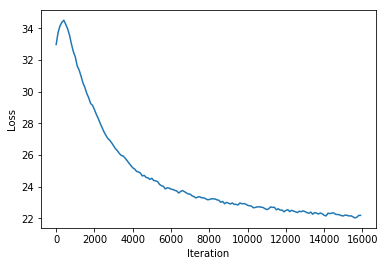

In [9]:
parameters, iteration, losses = model(data, index_to_char, char_to_index)
plt.plot(iteration, losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()
